In [5]:
# ------------------------------------------------------------------------
# Author: Euihyun Choi, Structural Engineering Intern. Date: July 20, 2022
# AECOM Technical Services Inc. 
# Project: Pilarcitos Dam and Reservoir Improvement Project
# Task: Preliminary design of sloping intake
# ------------------------------------------------------------------------

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import math

Location = 1

# Standard Units
ft = 1
kips = 1

# Dependant Units
inch = ft/12
lb = kips/1000
pcf = lb/ft**3
ksi = kips/inch/inch
psi = lb/inch/inch

# Material Properties
gamma_conc = 150 * pcf # Concrete density
gamma_st = 490 * pcf # Steel density
gamma_w = 62.4 * pcf # Water unit weight
fc = 4 * ksi
fy = 60 * ksi

###### Preliminary Geotech infomation:
gamma_soil = 135 * pcf # Soil unit weight
K_a = 0.53 # Active soil pressure coefficient
K_ae = 0.80 # Active earthquake soil pressure coefficient
K_p = 0.5 # Passive pressure coefficient for soil oriented downhill
fric_factor = 0.4 # tan(phi), Ultimate friction factor
c_soil = 0 # Cohesive Strength of soil
mu = 0.5
PGA = 1.39

sigma_bond = 12.5 * psi # very stiff clay, medium plasticity

# Water Level
El_NWS = 696.5*ft # Normal Water Surface Elevation
El_MWS = 704*ft # Maximum Water Surface Elevation

# Design elevations of intake
El_intake_lib = [[676.5, 666.5]*ft,[676.5, 666.5]*ft,[676.5, 666.5, 656.5, 646.5]*ft]
El_intake = El_intake_lib[Location-1]
El_outlet_lib = [656.5*ft, 656.5*ft, 635.5*ft]
El_outlet = El_outlet_lib[Location-1]
El_airvent = 705*ft

###### Design variables:
# Initial coordinate and slope of intake structure
crd_init_lib = [[158, 698], [102, 698], [41, 698]]
crd_init = crd_init_lib[Location-1]
slope_lib = [1/2, 1/2, 3/10]
slope = slope_lib[Location-1]

# Concrete encasement dimension
ID_st = 45*inch # steel lining I.D.
t_st = 1*inch # steel lining thickness
h_enc = 6*ft # concrete pipe encasement height
w_enc = 6*ft # concrete pipe encasement width

ID_st_v = 12*inch # steel lining I.D. of air vent pipe
t_st_v = 0.3*inch # steel lining thickness of air vent pipe
h_enc_v = 2*ft # air vent pipe encasement height
w_enc_v = 2*ft # air vent pipe encasement width

ID_pip_air = ID_st_v/2 # default: half of air vent pipe I.D.

# Block dimension
h_key = 3*ft # keyway height
L_key = 2*ft # keyway length
h_blk = 12*ft # encasement block height
L_blk = 8*ft # encasement block length
w_blk = 8*ft # encasement block width

ID_st_int = 20*inch # intake pipe steel lining I.D.
t_st_int = t_st*0.5 # intake pipe steel lining thickness
L_int = L_blk/4 # intake pipe length

h_intake = (h_blk - h_enc*np.sqrt(slope**2+1))/2 # default, but we can manually set up this

# Thrust block dimension
h_tst1 = 9*ft
h_tst2 = 7*ft
L_tst = 8*ft
d_tst = 4*ft
w_tst = 8*ft

h_key_tst = h_key
L_key_tst = L_key

# Air vent block dimension
h_key_v = 1*ft # keyway height
L_key_v = 1*ft # keyway length
h_blk_v = 6*ft # encasement block height
L_blk_v = 4*ft # encasement block length
w_blk_v = 4*ft # encasement block width

# Anchor design
theta_anc = 20
N_anc = 2 # the number of anchor per side
FS_req = 1.1
L_anc = 50*ft

%run -i "dimension_check.ipynb"

Model dimension is OK


In [2]:
# Determine the station coordinate
sta = [[crd_init[0], crd_init[1] + h_enc_v*np.sqrt(1+slope**2)/2]]

for El in El_intake:
    y_temp = El + h_intake - h_blk + h_enc*np.sqrt(1+slope**2)/2
    x_temp = (sta[0][1] - y_temp)/slope + sta[0][0]
    sta.append([x_temp - L_blk, y_temp + L_blk*slope])
    sta.append([x_temp, y_temp])
sta.append([x_temp + (y_temp - El_outlet)/slope - L_tst + d_tst, El_outlet + (L_tst - d_tst)*slope])
sta.append([x_temp + (y_temp - El_outlet)/slope, El_outlet])

In [3]:
# View reference image
reference_image = 'off' # 'on' or 'off'
design_variable_image = 'off' # 'on' or 'off'
bedline_image = 'off' # 'on' or 'off'

%run -i "view_image.ipynb"

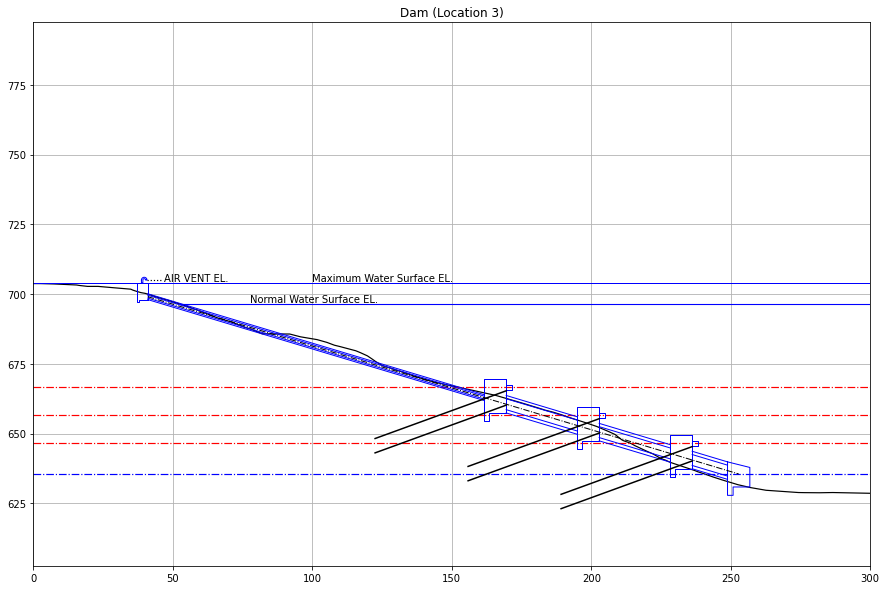

In [4]:
# plot overview
window_setup_x = [[50, 260], [0, 205], [0, 300]]
window_setup_y = [[640, 760], [640, 760], [640, 760]]
window_x = window_setup_x[Location-1]
window_y = window_setup_y[Location-1]

fig_size = [15,10] # dimension: inches
w_line = 1
%run -i "overview_plot.ipynb"

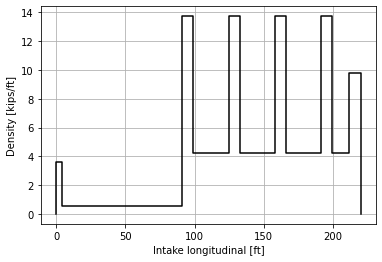

In [37]:
# Sliding check

# Component Volume & Weight Calculation

El_w = El_NWS
flag = 0
for i in range(len(sta)):
    if sta[i][1] <= El_w and flag == 0:
        sink_sta = i
        flag = 1

# Air vent pipe
A_pip_inner_v = ID_st_v**2*math.pi/4
A_pip_outer_v = (ID_st_v+2*t_st_v)**2*math.pi/4
A_pip_conc_v = w_enc_v*h_enc_v- A_pip_outer_v
A_pip_st_v = A_pip_outer_v - A_pip_inner_v

L_pip_v = np.linalg.norm(np.array(sta[0]) - np.array(sta[1]))
V_pip_conc_v = L_pip_v*A_pip_conc_v
V_pip_st_v = L_pip_v*A_pip_st_v

k = np.maximum(1-sink_sta, 0)
if sink_sta == 1:
    k = (El_w - sta[1][1])/(sta[0][1] - sta[1][1])
    
W_pip_v = V_pip_conc_v*gamma_conc + V_pip_st_v*gamma_st
Fb_pip_v = k*(V_pip_conc_v + V_pip_st_v)*gamma_w

# Intake Pipes between blocks
A_pip_inner = ID_st**2*math.pi/4
A_pip_outer = (ID_st+2*t_st)**2*math.pi/4
A_pip_conc = w_enc*h_enc- A_pip_outer
A_pip_st = A_pip_outer - A_pip_inner

L_pip = []
V_pip_conc = []
V_pip_st = []
W_pip = []
Fb_pip = []
for i in range(len(El_intake)):
    L_pip.append((sta[(i+1)*2+1][0] - sta[(i+1)*2][0])*np.sqrt(1+slope**2))
    V_pip_conc.append(L_pip[-1]*A_pip_conc)
    V_pip_st.append(L_pip[-1]*A_pip_st)
    W_pip.append(V_pip_conc[-1]*gamma_conc+V_pip_st[-1]*gamma_st)
    k = np.minimum(np.maximum(1-sink_sta+(i+1)*2, 0),1)
    if sink_sta == (i+1)*2+1:
        k = (El_w - sta[(i+1)*2+1][1])/(sta[(i+1)*2][1] - sta[(i+1)*2+1][1])
    Fb_pip.append(k*(V_pip_conc[-1] + V_pip_st[-1])*gamma_w)

A_pip_inner_int = ID_st_int**2*math.pi/4
A_pip_outer_int = (ID_st_int+2*t_st_int)**2*math.pi/4
A_pip_st_int = A_pip_outer_int - A_pip_inner_int

## Blocks
# Intake block; intake pipe length: 75% of encasement block length
V_blk_conc = (L_blk*h_blk+L_key*h_key)*w_blk - A_pip_outer*L_blk*np.sqrt(1+slope**2) - 3/4*L_blk*A_pip_outer_int
V_blk_st = A_pip_st*L_blk*np.sqrt(1+slope**2) - t_st*A_pip_outer_int + 3/4*L_blk*A_pip_st_int

W_blk = V_blk_conc*gamma_conc + V_blk_st*gamma_st
Fb_blk = []
for i in range(len(El_intake)):
    bot_el = sta[2*(i+1)][1] - h_enc*np.sqrt(1+slope**2)/2
    top_el = bot_el + h_blk
    k = np.maximum(np.minimum((El_w - bot_el)/h_blk, 1), 0)
    Fb_blk.append(k*(V_blk_conc+V_blk_st)*gamma_w)

# Thrust block; air vent length: 1/2 of height + 1/2 of length (incline)
V_tst_conc = ((h_tst1+h_tst2)/2*L_tst + L_key_tst*h_key_tst)*w_tst - A_pip_outer*(L_tst-d_tst)*np.sqrt(1+slope**2)
V_tst_st = A_pip_st*(L_tst-d_tst)*np.sqrt(1+slope**2)
W_tst = V_tst_conc*gamma_conc + V_tst_st*gamma_st
top_el = sta[-2][1] + h_enc*np.sqrt(1+slope**2)/2
bot_el = top_el - h_tst1
k = np.maximum(np.minimum((El_w - bot_el)/h_tst1, 1), 0)
Fb_tst = k*(V_tst_conc+V_tst_st)*gamma_w

# Air vent block
V_blk_v_conc = (L_blk_v*h_blk_v+L_key_v*h_key_v)*w_blk_v - A_pip_outer_v*(L_blk_v/2*np.sqrt(1+slope**2)+h_blk_v/2)
V_blk_v_st = A_pip_st_v*(L_blk_v/2*np.sqrt(1+slope**2)+h_blk_v/2)
W_blk_v = V_blk_v_conc*gamma_conc + V_blk_v_st*gamma_st
bot_el = sta[0][1] - h_enc_v*np.sqrt(1+slope**2)/2
top_el = bot_el + h_blk_v
k = np.maximum(np.minimum((El_w - bot_el)/h_blk_v, 1), 0)
Fb_blk_v = k*(V_blk_v_conc+V_blk_v_st)*gamma_w

%run -i "weight_dist.ipynb"

In [39]:
# Soil pressure
H_blk_s = (L_blk*slope + h_key)/np.sqrt(1+slope**2)
H_blk_s_side = H_blk_s + h_enc/2
H_v_s = (L_blk_v*slope + h_key_v)/np.sqrt(1+slope**2)
H_v_s_side = H_v_s + h_enc_v/2
H_tst_s = (h_tst1 + h_key_tst)/np.sqrt(1+slope**2) - h_enc
H_tst_s_side = (h_tst1 + h_key_tst)/np.sqrt(1+slope**2)
H_tst_s_p = (L_tst*slope + h_tst2 + h_key_tst)/np.sqrt(1+slope**2)

P_blk_a = 0.5*K_a*gamma_soil*H_blk_s**2*w_enc + 0.5*K_a*gamma_soil*H_blk_s_side**2*(w_blk-w_enc)
P_blk_ae = 0.5*K_ae*gamma_soil*H_blk_s**2*w_enc + 0.5*K_ae*gamma_soil*H_blk_s_side**2*(w_blk-w_enc)
P_blk_p = 0.5*K_p*gamma_soil*H_blk_s**2*w_enc + 0.5*K_p*gamma_soil*H_blk_s_side**2*(w_blk-w_enc)
P_v_a = 0.5*K_a*gamma_soil*H_v_s**2*w_enc_v + 0.5*K_a*gamma_soil*H_v_s_side**2*(w_blk_v-w_enc_v)
P_v_ae = 0.5*K_ae*gamma_soil*H_v_s**2*w_enc_v + 0.5*K_ae*gamma_soil*H_v_s_side**2*(w_blk_v-w_enc_v)
P_v_p = 0.5*K_p*gamma_soil*H_v_s**2*w_enc_v + 0.5*K_p*gamma_soil*H_v_s_side**2*(w_blk_v-w_enc_v)
P_tst_a = 0.5*K_a*gamma_soil*H_tst_s**2*w_enc + 0.5*K_a*gamma_soil*H_tst_s_side**2*(w_tst-w_enc)
P_tst_ae = 0.5*K_ae*gamma_soil*H_tst_s**2*w_enc + 0.5*K_ae*gamma_soil*H_tst_s_side**2*(w_tst-w_enc)
P_tst_p = 0.5*K_p*gamma_soil*H_tst_s_p**2*w_tst

P_blk = P_blk_a + P_blk_ae - P_blk_p
P_v = P_v_a + P_v_ae - P_v_p
P_tst = P_tst_a + P_tst_ae - P_tst_p
P_tot = P_blk*len(El_intake) + P_tst + P_v

# Weight
W_tot = W_blk*len(El_intake) + W_blk_v + W_tst + np.sum(W_pip) + W_pip_v # kips
print(W_blk, W_blk_v , W_tst , W_pip[0],W_pip[1] , W_pip_v)
# Buoyant force
Fb_tot = np.sum(Fb_blk) + Fb_blk_v + Fb_tst + np.sum(Fb_pip) + Fb_pip_v
print(Fb_blk, Fb_blk_v , Fb_tst  ,Fb_pip, Fb_pip_v)
# Inertia force
W_EQ = W_tot*PGA*2/3

# Factor of Safety
T = (W_tot - Fb_tot)/np.sqrt(1+slope**-2) + W_EQ/np.sqrt(1+slope**2) + P_tot
N = (W_tot - Fb_tot)/np.sqrt(1+slope**2) - W_EQ/np.sqrt(1+slope**-2)
FS = N*mu/T
print("Total weight: ", W_tot, "kips")
print("Total buoyant force: ", Fb_tot, "kips")
print("Net normal force: ", N, "kips")
print("Net tangential force: ", T, "kips")
print("Factor of Safety against sliding without anchors: ", FS)
theta = np.arctan(slope) + theta_anc/180*np.pi
F_anc_tot = (T - N*mu/FS_req)/np.cos(theta)
f_anc = F_anc_tot/N_anc/num_anc[Location-1]/2
print("Total Anchor load Required: ", F_anc_tot, "kips")
print("Anchor load Required: ", f_anc, "kips per anchor")

109.80720116555372 14.53984286670732 78.50636340869318 108.03036129695315 108.03036129695303 46.361882471041504
[44.3328205590164, 44.3328205590164, 44.3328205590164, 44.3328205590164] 0.0 32.06587105735092 [41.186381535318084, 41.18638153531804, 41.186381535318084, 20.59319076765902] 16.474634011397193
Total weight:  956.7431579479928 kips
Total buoyant force:  370.024122678427 kips
Net normal force:  307.2174529419 kips
Net tangential force:  1087.1590915571207 kips
Factor of Safety without anchors against sliding:  0.1412936962620058
Total Anchor load Required:  1181.758869580224 kips
Anchor load Required:  98.479905798352 kips per anchor
